In [2]:
import pandas as pd 
from matplotlib import pyplot as plt 
%matplotlib inline 
import matplotlib_venn
import re 
import numpy as np 

## Loading Protein information 

In [3]:
prot_fn = '../data/StringDB/9606.protein.info.v11.0.txt'

In [4]:
prot_data = {}
stringbd_synapse_genes = set()
with open(prot_fn) as f: 
    next(f)
    for line in f: 
        gene_id, gene_name, prot_size, anno = line.strip().split('\t') 
        synapse_anno = True if re.search('[Ss]ynap', anno) else False
        if synapse_anno: 
            stringbd_synapse_genes.add(gene_name)
        prot_data[gene_id] = [gene_name, prot_size, anno]

## Loading synapse gene data

In [5]:
synapse_fn = '../data/synapse_genes.txt'
with open(synapse_fn) as f:
    synapse_genes = set([x.strip() for x in f])

## Analyzing the difference between the synapse gene sets 

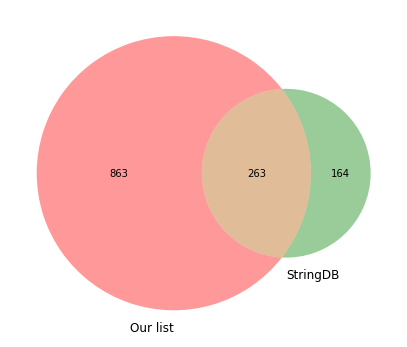

In [6]:
shared = stringbd_synapse_genes.intersection(synapse_genes)
num_shared = len(shared)
a = len(synapse_genes) - num_shared
b = len(stringbd_synapse_genes) - num_shared
ab = len(shared)

fig, ax = plt.subplots(figsize=(8,6))
matplotlib_venn.venn2(subsets=(a, b, ab), set_labels=['Our list', 'StringDB'])

## Filtering StringDB interactions for synapse genes 

In [7]:
stringdb_fn = '../data/StringDB/string_interactions.tsv'
combined_synapse_genes = synapse_genes.union(stringbd_synapse_genes)

In [8]:
synapse_interactions_fn = '../output/StringDB/string_synapse_interactions.tsv'
with open(stringdb_fn) as fr, open(synapse_interactions_fn, 'w') as fw: 
    next(fr)
    for line in fr: 
        node, node2, node1_id, node2_id, \
        node1_ext_id, node2_ext_id, nbr_on_chrom, gene_fusion, \
        phylo_co, homology, coexpression, exp_interaction, \
        database_anno, auto_textmine, combined_score = line.split('\t')
        
        if node in combined_synapse_genes: 
            fw.write(line)
        
        elif node2 in combined_synapse_genes:
            fw.write(line)

In [23]:
# Calculating the optimal alpha value for CliXo
synapse_df = pd.read_table(synapse_interactions_fn, header=None)
clixo_alpha = np.std(synapse_df.iloc[:, -1]) * 2 
clixo_alpha

0.4221486618228198